In [455]:
##nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html

# !pip install "jupyterlab>=3" "ipywidgets>=7.6"
# !pip install jupyter-dash
# !jupyter lab build


# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# !pip install category_encoders
# !pip install xgboost
# !pip install lightgbm --user
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector
from datetime import timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2_score
import sklearn.model_selection

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

# Descriptive statistics

In [593]:
date_train = '2021-06-01'
date_eval = '2021-07-01'

df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_0922.csv')
df= df_raw.copy()
df['effective_start_date'] = pd.to_datetime(df['effective_start_date'])
df = df[df['effective_start_date']<=date_eval]

display(df.head(2))
print(df.isnull().sum())
display(df.describe())


grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
        'program_type','effective_start_date']
df = df[['first_views','premiering_hours_runtime'] + grpby_title].groupby(by=grpby_title).sum().reset_index()
df['start_year'] = pd.to_datetime(df['effective_start_date']).dt.year
df['start_month'] = pd.to_datetime(df['effective_start_date']).dt.month
df['start_year_month'] = df['effective_start_date'].dt.strftime('%Y-%m')
df['start_quarter'] = df['effective_start_date'].dt.quarter

print(df.shape)
display(df.describe())
print('# title: ', df.title_name.nunique())
df = df[df['first_views']!=0]
print(df.shape)
df['first_views_log'] = np.log10(df['first_views'])

,Unnamed: 0,title_id,title_name,season_number,content_category,content_source,program_type,category,tier,effective_start_date,request_date,premiere_ind,asset_premiere_count,premiering_hours_runtime,first_views,hours_viewed,days_since_premiere,days_on_platform,finished_window_flag
0,0,GX6qNfA264sPCwgEAAAAD,Baby God,0,movies,HBO,original,Documentary Features,3,2020-12-03,2021-01-09,0,0,0.0,15,1781.141,37,291,1
1,1,GX6qNfA264sPCwgEAAAAD,Baby God,0,movies,HBO,original,Documentary Features,3,2020-12-03,2021-01-10,0,0,0.0,17,2138.678,38,291,1


Unnamed: 0                  0
title_id                    0
title_name                  0
season_number               0
content_category            0
content_source              0
program_type                0
category                    0
tier                        0
effective_start_date        0
request_date                0
premiere_ind                0
asset_premiere_count        0
premiering_hours_runtime    0
first_views                 0
hours_viewed                0
days_since_premiere         0
days_on_platform            0
finished_window_flag        0
dtype: int64


,Unnamed: 0,season_number,tier,premiere_ind,asset_premiere_count,premiering_hours_runtime,first_views,hours_viewed,days_since_premiere,days_on_platform,finished_window_flag
count,24952.000000,24952.000000,24952.000000,24952.000000,24952.000000,24952.000000,24952.000000,2.495200e+04,24952.000000,24952.000000,24952.000000
mean,14219.405779,3.161710,2.606805,0.011302,0.066167,0.034053,735.776691,2.915969e+04,44.597948,299.374078,0.978118
std,8618.461170,9.670572,0.619166,0.105709,0.882313,0.323366,8215.019659,1.945573e+05,26.328659,109.667296,0.146301
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,81.000000,0.000000
25%,6328.750000,0.000000,2.000000,0.000000,0.000000,0.000000,5.000000,6.153547e+02,22.000000,221.000000,1.000000
50%,14186.500000,1.000000,3.000000,0.000000,0.000000,0.000000,30.000000,3.159943e+03,44.000000,312.000000,1.000000
75%,21602.250000,1.000000,3.000000,0.000000,0.000000,0.000000,188.000000,1.269559e+04,67.000000,389.000000,1.000000
max,28934.000000,51.000000,3.000000,1.000000,35.000000,15.436000,732742.000000,9.817929e+06,90.000000,481.000000,1.000000


(282, 14)


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_month,start_quarter
count,282.000000,282.000000,2.820000e+02,282.000000,282.000000,282.000000,282.000000
mean,2.588652,3.078014,6.510319e+04,3.013089,2020.354610,7.131206,2.691489
std,0.632128,9.565709,2.438481e+05,2.446509,0.479245,3.366226,1.100242
min,1.000000,0.000000,1.200000e+01,0.000000,2020.000000,1.000000,1.000000
25%,2.000000,0.000000,1.304250e+03,1.439000,2020.000000,5.000000,2.000000
50%,3.000000,1.000000,5.736000e+03,1.980000,2020.000000,7.000000,3.000000
75%,3.000000,1.000000,2.803425e+04,4.542750,2021.000000,10.000000,4.000000
max,3.000000,51.000000,2.727097e+06,15.436000,2021.000000,12.000000,4.000000


# title:  238
(282, 14)


In [160]:
# data availability 
df.groupby(by=['start_year','start_month','tier']).agg({'title_id':'count'})

title_id
start_year start_month tier          
2020       5           1            3
                       3            5
           6           1            3
                       2            8
                       3           11
           7           2            3
                       3           12
           8           1            1
                       2            5
                       3           22
           9           1            1
                       2            3
                       3           15
           10          1            2
                       2            2
                       3           20
           11          1            1
                       2           22
                       3           20
           12          1            2
                       2            4
                       3           17
2021       1           1            1
                       2            4
                       3           14
           2           2            6
                       3           10
           3           1            2
                       2            3
                       3           10
           4           1            3
                       2            2
                       3           12
           5           1            3
                       2            4
                       3            8
           6           2            3
                       3           12
           7           2            3

,first_views
count,2.810000e+02
mean,6.532421e+04
std,2.442548e+05
min,1.200000e+01
1%,2.100000e+01
5%,1.050000e+02
10%,3.350000e+02
25%,1.285000e+03
50%,5.800000e+03
75%,2.835400e+04


title_id first_views                              \
                       nunique         sum       mean       std    min   
tier content_category                                                    
1    movies                  6     7612474  1087496.0  999907.0  43052   
     series                 10     1747840   174784.0  148085.0   6203   
     special                 4     1390145   347536.0  378901.0  25780   
2    movies                 26     3583165   127970.0  179821.0   1234   
     series                 24     1881420    47036.0  120723.0     21   
     special                 4      192115    48029.0   52532.0  11903   
3    movies                 76     1094649    14403.0   45783.0     12   
     series                 76      833511     8419.0   15606.0     15   
     special                13       20783     1599.0    1602.0    236   

                                                                           \
                           q10       q25        q50        q75        q90   
tier content_category                                                       
1    movies            59660.0  297628.0  1074951.0  1586059.0  2301136.0   
     series            23046.0   58491.0   141230.0   280893.0   366262.0   
     special           51843.0   90938.0   248280.0   504878.0   722634.0   
2    movies            20234.0   32638.0    49927.0   122083.0   395115.0   
     series              310.0     958.0     8336.0    55145.0    86187.0   
     special           16005.0   22158.0    27070.0    52940.0    96819.0   
3    movies              416.0    1642.0     4765.0    12766.0    19394.0   
     series              187.0     947.0     2632.0     9020.0    19453.0   
     special             262.0     658.0      784.0     1934.0     3735.0   

                                
                           max  
tier content_category           
1    movies            2727097  
     series             420643  
     special            867805  
2    movies             635584  
     series             758825  
     special            126072  
3    movies             352452  
     series              99113  
     special              5432

title_id first_views             \
                                              nunique         sum       mean   
tier content_category category                                                 
1    movies           Pay1                          2      113784    56892.0   
                      Popcorn                       3     5819210  1939737.0   
                      Scripted Features             2     1679480   839740.0   
     series           Kids & Family                 3      163339    54446.0   
                      Scripted Comedy Series        1      242337   242337.0   
                      Scripted Drama Series         6     1342164   223694.0   
     special          Specials                      4     1390145   347536.0   
2    movies           Documentary Features          2       81525    40762.0   
                      Pay1                         11      470989    42817.0   
                      Popcorn                       6     2470510   411752.0   
                      Scripted Features             7      553412    79059.0   
                      Specials                      1        1234     1234.0   
                      Unscripted Series             1        5495     5495.0   
     series           Docu-Series                   7      349855    49979.0   
                      Documentary Features          1      108619   108619.0   
                      Kids & Family                 2       33894     2118.0   
                      Scripted Comedy Series        3      134680    33670.0   
                      Scripted Drama Series         5     1014846   202969.0   
                      Unscripted Series             6      239526    34218.0   
     special          Specials                      4      192115    48029.0   
3    movies           Documentary Features         36      347851     9663.0   
                      International                 6        3283      547.0   
                      Pay1                         28      373222    13329.0   
                      Scripted Features             2      355438   177719.0   
                      Specials                      4       14855     3714.0   
     series           Docu-Series                   7       79864    11409.0   
                      Documentary Features          3       96070    32023.0   
                      International                25      132251     4408.0   
                      Kids & Family                10      126382     6018.0   
                      Scripted Comedy Series        6       61397     8771.0   
                      Scripted Drama Series         6       90096    12871.0   
                      Unscripted Series            19      247451    10310.0   
     special          International                 2         588      294.0   
                      Kids & Family                 5        4688      938.0   
                      Specials                      6       15507     2584.0   

                                                                            \
                                                   std      min        q10   
tier content_category category                                               
1    movies           Pay1                     19573.0    43052    45820.0   
                      Popcorn                 828790.0  1074951  1263393.0   
                      Scripted Features       445783.0   524524   587567.0   
     series           Kids & Family            46141.0     6203    16760.0   
                      Scripted Comedy Series       NaN   242337   242337.0   
                      Scripted Drama Series   161706.0    24918    41622.0   
     special          Specials                378901.0    25780    51843.0   
2    movies           Documentary Features     12665.0    31807    33598.0   
                      Pay1                     19828.0    10683    24327.0   
                      Popcorn                 215159.0   153249   17

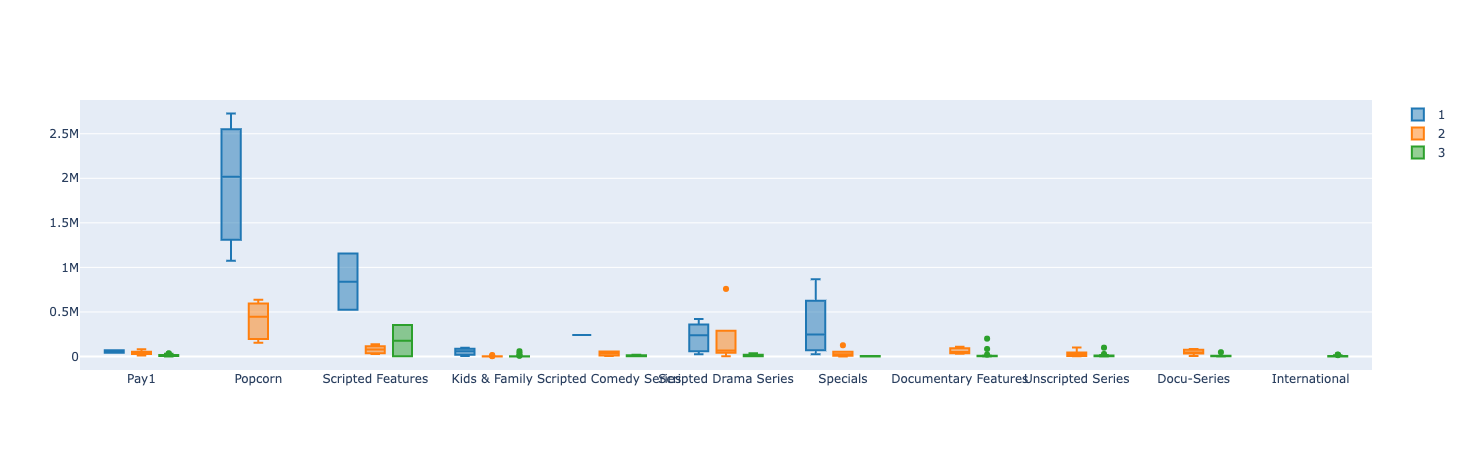

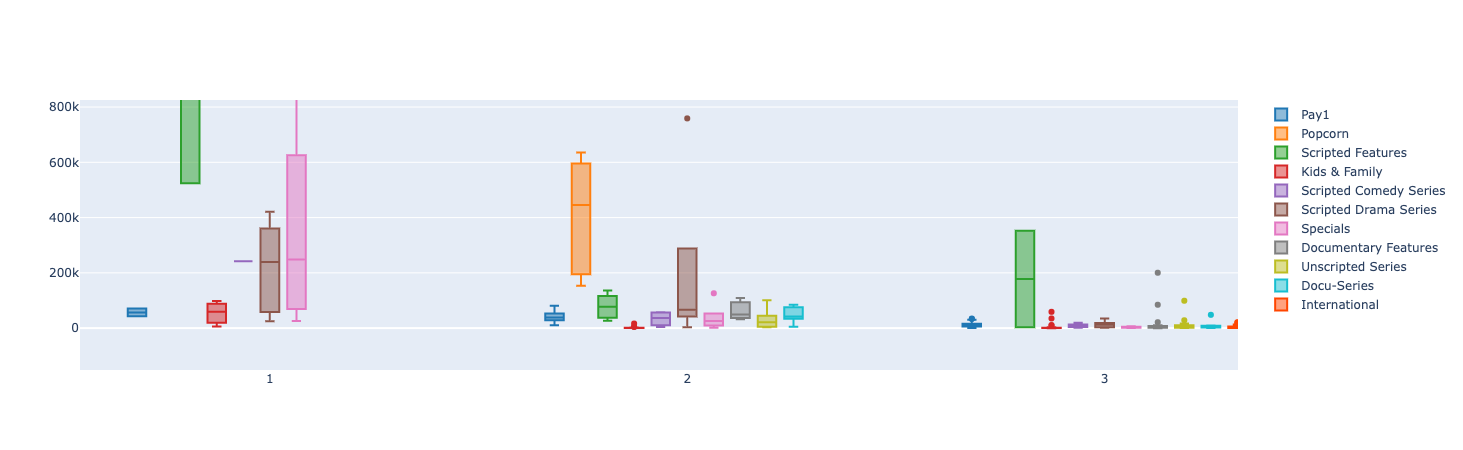

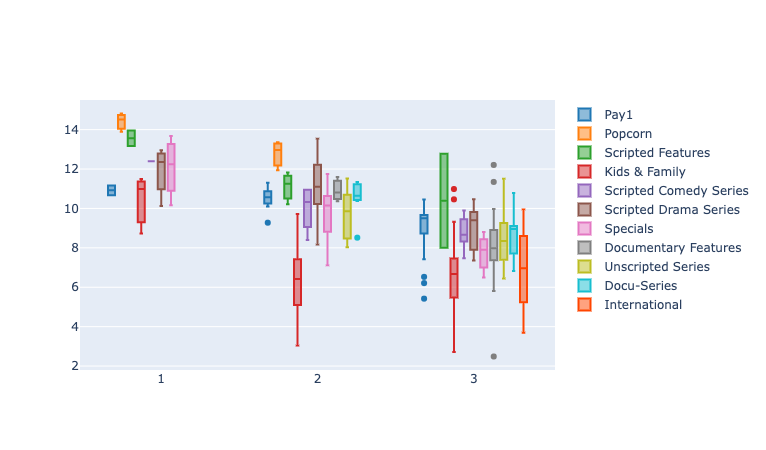

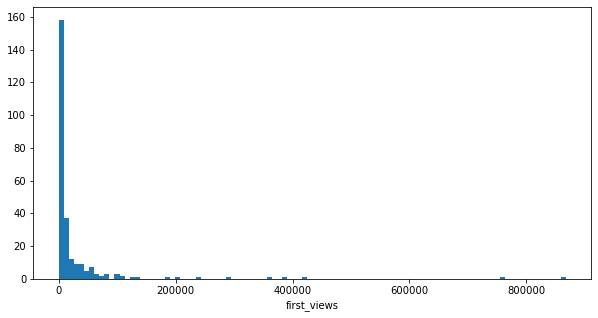

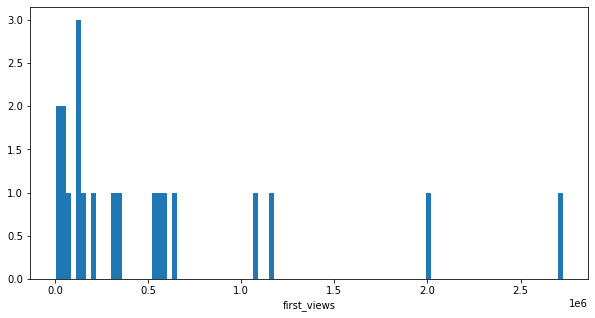

In [943]:
# target variable stats 
def get_distribution(df_in, grpby):
    display(df[['first_views','title_id'] + grpby].groupby(by=grpby).agg({'title_id':'nunique','first_views':['sum','mean','std','min', q10, q25, q50, q75, q90,'max']}).round())

def get_box_plot(df, y_var):
    fig, ax = plt.subplots(figsize = (20, 10))
    sns.boxplot(x='category',y='first_views', data=df, hue='tier', ax=ax, showfliers = False)
#     ax.set_ylabel(('first_views'))
    plt.show()
    
def get_hist_plot(df, y_var):
    fig, ax = plt.subplots(figsize = (10, 5))
    plt.hist(df[[y_var]], bins=100)
    ax.set_xlabel(y_var)
    plt.show()

def q10(x):
    return x.quantile(0.1)
def q25(x):
    return x.quantile(0.25)
def q50(x):
    return x.quantile(0.5)
def q75(x):
    return x.quantile(0.75)
def q90(x):
    return x.quantile(0.9)

display(df[['first_views']].describe(percentiles=percents))

get_distribution(df, ['tier','content_category',])
get_distribution(df, ['tier','content_category','category',])


fig=go.Figure()
for i, tier in enumerate(df['tier'].unique()):
    df_plot=df[df['tier']==tier]
    fig.add_trace(go.Box(x=df_plot['category'], y=df_plot['first_views'],
                         line=dict(color=colorlist[i]),
                         name=f'{tier}'))

fig.update_layout(boxmode='group', xaxis_tickangle=0)
fig.show()

fig=go.Figure()
for i, tier in enumerate(df['category'].unique()):
    df_plot=df[df['category']==tier]
    fig.add_trace(go.Box(x=df_plot['tier'], y=df_plot['first_views'],
                         line=dict(color=colorlist[i]),
                         name=f'{tier}'))

fig.update_layout(boxmode='group', xaxis_tickangle=0)
fig.show()


fig=go.Figure()
for i, tier in enumerate(df['category'].unique()):
    df_plot=df[df['category']==tier]
    fig.add_trace(go.Box(x=df_plot['tier'], y=df_plot['first_views_log'],
                         line=dict(color=colorlist[i]),
                         name=f'{tier}'))

fig.update_layout(boxmode='group', xaxis_tickangle=0)
fig.show()

get_hist_plot(df[~(df.category.isin(["Scripted Features","Popcorn"]))], 'first_views')
get_hist_plot(df[(df.category.isin(["Scripted Features","Popcorn"]))], 'first_views')

# plt.xticks(rotation=45)

In [843]:
np.exp(12.14)

187212.5722077534

count    2.820000e+02
mean     6.510319e+04
std      2.438481e+05
min      1.200000e+01
25%      1.304250e+03
50%      5.736000e+03
75%      2.803425e+04
max      2.727097e+06
Name: first_views, dtype: float64

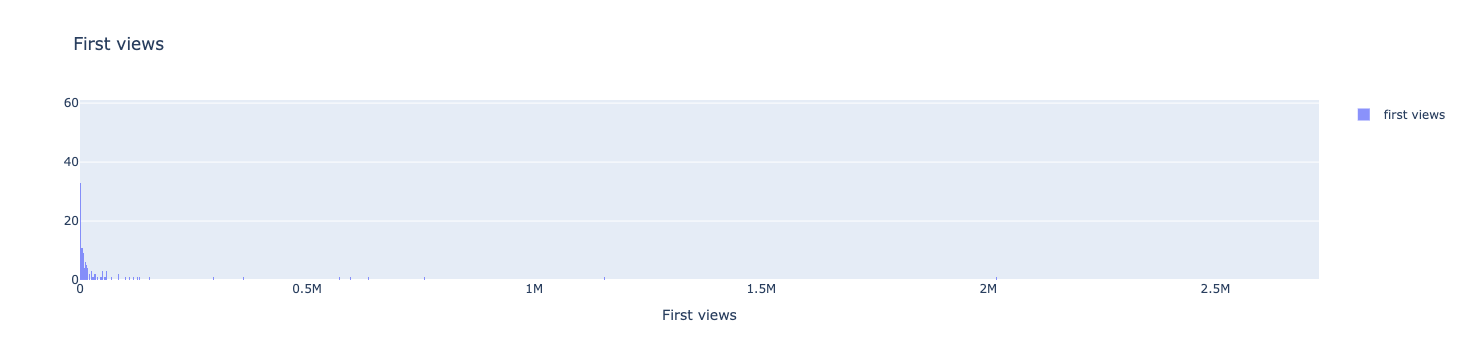

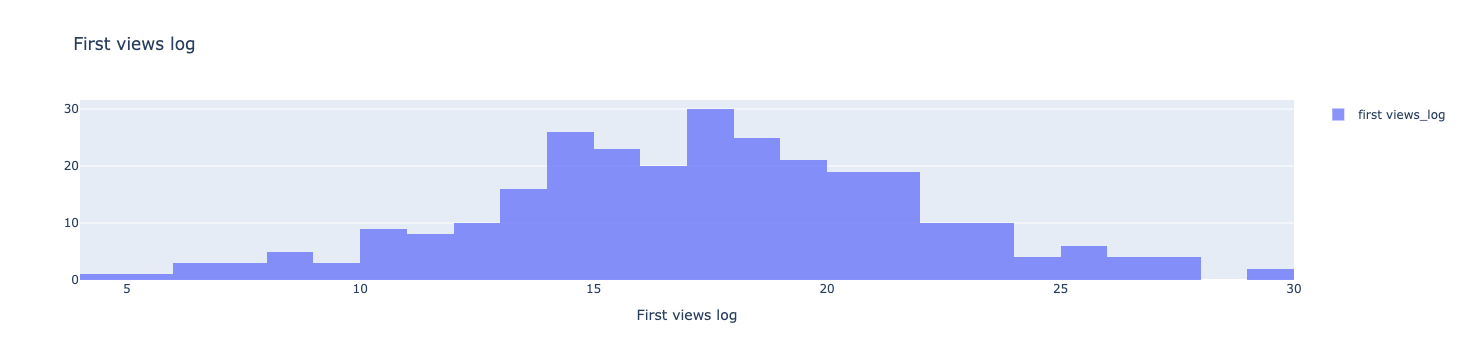

In [650]:
df['first_views_log'] = np.log(df['first_views'])*2
display(df['first_views'].describe())


kwargs={'dflist':[df]  ## List of dataframes 
        ,'varlist':['first_views'] ## Variables to be plotted
        ,'title':'First views'  ## Plot title
        ,'labellist':['first views']
       ,'option':{'xbins':{'size':1000}}} ## Labels to be shown in legend
fig = histogram_plot(**kwargs)


kwargs={'dflist':[df]  ## List of dataframes 
        ,'varlist':['first_views_log'] ## Variables to be plotted
        ,'title':'First views log'  ## Plot title
        ,'labellist':['first views_log']} ## Labels to be shown in legend
fig = histogram_plot(**kwargs)

# Features
augment input data? 
get more features?
regularize 
lightgbm, catboost, xgboost, random forest, 

In [509]:
print(df.columns)
print(df_raw.columns)

target = 'first_views_log'

features_cat=[
    'start_year',
    'start_quarter',
    'start_month',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont=[
    'season_number',
    'premiering_hours_runtime'
]

## Bivariate 
for i in features_cat:
    display(df.groupby(by=i).mean())


Index(['tier', 'content_category', 'category', 'title_name', 'title_id',
       'season_number', 'program_type', 'effective_start_date', 'first_views',
       'premiering_hours_runtime', 'start_year', 'start_month',
       'start_year_month', 'start_quarter', 'first_views_log'],
      dtype='object')
Index(['Unnamed: 0', 'title_id', 'title_name', 'season_number',
       'content_category', 'content_source', 'program_type', 'category',
       'tier', 'effective_start_date', 'request_date', 'premiere_ind',
       'asset_premiere_count', 'premiering_hours_runtime', 'first_views',
       'hours_viewed', 'days_since_premiere', 'days_on_platform',
       'finished_window_flag'],
      dtype='object')


,tier,season_number,first_views,premiering_hours_runtime,start_month,start_quarter,first_views_log
start_year,,,,,,,
2020,2.598901,3.983516,51871.71978,2.950703,9.126374,3.32967,8.547233
2021,2.570000,1.430000,89184.47000,3.126630,3.500000,1.53000,8.926182


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_month,first_views_log
start_quarter,,,,,,,
1,2.620000,1.860000,105759.620000,3.293440,2021.000000,1.920000,8.834433
2,2.467532,0.948052,63760.051948,3.067286,2020.610390,5.259740,9.198564
3,2.723077,0.569231,28682.661538,3.016785,2020.046154,8.015385,8.573544
4,2.577778,7.388889,69969.133333,2.808300,2020.000000,10.988889,8.232481


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_quarter,first_views_log
start_month,,,,,,,
1,2.684211,3.526316,49209.578947,4.258632,2021.000000,1.0,8.900685
2,2.625000,1.062500,67182.500000,2.958000,2021.000000,1.0,9.245272
3,2.533333,0.600000,218538.600000,2.428667,2021.000000,1.0,8.312284
4,2.529412,1.117647,83929.882353,3.502941,2021.000000,2.0,9.146425
5,2.304348,1.043478,82300.173913,3.529391,2020.652174,2.0,9.995836
6,2.540541,0.810811,42967.891892,2.579865,2020.405405,2.0,8.726919
7,2.666667,0.611111,17053.611111,2.446222,2020.166667,3.0,8.848728
8,2.750000,0.464286,36008.392857,2.809536,2020.000000,3.0,8.623554
9,2.736842,0.684211,28903.842105,3.862737,2020.000000,3.0,8.239143


,season_number,first_views,premiering_hours_runtime,start_year,start_month,start_quarter,first_views_log
tier,,,,,,,
1,0.500000,488793.500000,3.686682,2020.409091,6.318182,2.409091,11.985618
2,9.361111,78565.277778,3.243319,2020.347222,7.472222,2.791667,9.732961
3,0.973404,10366.718085,2.846090,2020.351064,7.095745,2.686170,7.892329


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_month,start_quarter,first_views_log
content_category,,,,,,,,
movies,2.607143,0.000000,109761.482143,1.674321,2020.348214,7.294643,2.723214,9.210082
series,2.597315,5.825503,29951.483221,4.314604,2020.375839,6.906040,2.630872,8.300889
special,2.428571,0.000000,76335.380952,0.918619,2020.238095,7.857143,2.952381,8.564430


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_month,start_quarter,first_views_log
program_type,,,,,,,,
acquired,2.418182,0.000000,171678.709091,1.855927,2020.400000,6.745455,2.545455,10.097869
original,2.629956,3.823789,39280.929515,3.293458,2020.343612,7.224670,2.726872,8.338466


,tier,season_number,first_views,premiering_hours_runtime,start_year,start_month,start_quarter,first_views_log
category,,,,,,,,
Docu-Series,2.500000,1.000000,30694.214286,3.959643,2020.357143,7.000000,2.714286,9.593203
Documentary Features,2.928571,0.095238,15096.785714,1.727762,2020.357143,7.142857,2.666667,8.276465
International,3.000000,1.078947,3582.157895,4.668000,2020.421053,6.736842,2.578947,6.897612
Kids & Family,2.511111,14.777778,7295.622222,2.092178,2020.133333,8.666667,3.155556,6.707614
Pay1,2.634146,0.000000,23365.731707,1.816146,2020.292683,7.365854,2.780488,9.540517
Popcorn,1.600000,0.000000,829271.800000,2.029000,2020.800000,4.700000,1.800000,12.794142
Scripted Comedy Series,2.500000,1.666667,36534.500000,3.181750,2020.750000,4.500000,1.833333,9.510056
Scripted Drama Series,2.055556,1.500000,135950.333333,6.478889,2020.333333,6.666667,2.555556,10.549261
Scripted Features,2.000000,0.000000,235302.727273,2.000273,2020.363636,7.454545,2.818182,11.428477


In [529]:
## Stepwise regression 
from sklearn.linear_model import LinearRegression

def run_regression(df, features_cat, features_cont, print_coeff=False):
    features = features_cat + features_cont
    x = df[features]
    ohe = OneHotEncoder(cols=features_cat, 
                        handle_unknown='return_nan',
                       handle_missing='return_nan',
                       use_cat_names=True) 
    x_ohe = ohe.fit_transform(df[features])

    # fit
    lm = LinearRegression()
    model = lm.fit(x_ohe, df[target])
    
    # predict
    y_pred = model.predict(x_ohe)

    print(features)
    # Fit (in sample)
    print('MAE: %.2f'
      % MAE(df[target], y_pred))
    print('r2: %.2f'
      % r2_score(df[target], y_pred))
    
    # coeffs
    if print_coeff==True:
        df_coeff = pd.concat([pd.DataFrame(x_ohe.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1) 
        df_coeff.columns=['feature','coeff']
        df_coeff['coeff_abs']=df_coeff.coeff.abs()
        display(df_coeff.sort_values(by='coeff_abs', ascending=False))
        
    return


features_cat_tot=[
    'tier',
    'content_category',
    'category',
    'program_type',
    'start_quarter',
    'start_year',
    'start_month',
]

features_cont_tot=[
    'season_number',
    'premiering_hours_runtime'
]


target = 'first_views_log'
features_cont=[]

i=0
for i in range(0,len(features_cat_tot)):
    run_regression(df, features_cat_tot[0:i+1], features_cont)
    
for i in range(0,len(features_cont_tot)):
    run_regression(df, features_cat_tot, features_cont_tot[0:i+1])



is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


['tier']
MAE: 1.53
r2: 0.29
['tier', 'content_category']
MAE: 1.46
r2: 0.33
['tier', 'content_category', 'category']
MAE: 1.13
r2: 0.59
['tier', 'content_category', 'category', 'program_type']
MAE: 1.12
r2: 0.59
['tier', 'content_category', 'category', 'program_type', 'start_quarter']
MAE: 1.13
r2: 0.59
['tier', 'content_category', 'category', 'program_type', 'start_quarter', 'start_year']
MAE: 1.10
r2: 0.60
['tier', 'content_category', 'category', 'program_type', 'start_quarter', 'start_year', 'start_month']
MAE: 1.08
r2: 0.61
['tier', 'content_category', 'category', 'program_type', 'start_quarter', 'start_year', 'start_month', 'season_number']
MAE: 1.06
r2: 0.62


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


['tier', 'content_category', 'category', 'program_type', 'start_quarter', 'start_year', 'start_month', 'season_number', 'premiering_hours_runtime']
MAE: 1.06
r2: 0.63


## Prediction

In [917]:
def _encode(df, categoricals):
    """
    perform category encoding on the data
    :param df: dataframe to be encoded
    :param categoricals: list of name of categorical columns
    :return ohe, x_ohe: OHE object and OHE-encoded data
    """
    ohe = OneHotEncoder(cols=categoricals, 
                        handle_unknown='return_nan',
                       handle_missing='return_nan',
                       use_cat_names=True) 
    x_ohe = ohe.fit_transform(df)
    return ohe, x_ohe


def train_lr(df_train, features_cat, features_cont, target):
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
  
    # fit
    lm = LinearRegression()
    model = lm.fit(x_ohe, y_train)
       
    return model, ohe

def predict_lr(df_test, model, ohe, features_cat, features_cont, target, postfix):    
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    y_pred = model.predict(x_ohe_test)

    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_{}'.format(postfix)] = np.exp(pred)
  
    rmse = np.sqrt(MSE(np.exp(y_test), np.exp(pred)))
    mae = MAE(np.exp(y_test), np.exp(pred))
    print("Aggergate error : % f" %(np.exp(pred).sum()-np.exp(y_test).sum()))
    print("RMSE : % f" %(rmse))
    print("MAE : % f" %(mae)) 
    
    return df_pred


def train_xgb(df_train, features_cat, features_cont, target, param):
  
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
    dm_train = xgb.DMatrix(x_ohe, label=y_train)
    
    ## train 
    model = xgb.train(params = param, dtrain = dm_train, num_boost_round = 10)
    
    return model, ohe

def predict_xgb(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    dm_test = xgb.DMatrix(x_ohe_test, label=y_test)
    pred = model.predict(dm_test)
    
    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_{}'.format(postfix)] = np.exp(pred)
    df_pred.head()
    
    return df_pred


def train_lgbm(df_train, features_cat, features_cont, target, param):       
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)

    x_train = lightgbm.Dataset(x_ohe, label=y_train)
    model = lightgbm.train(param, x_train, verbose_eval = -1)

    return model, ohe


def predict_lgbm(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    pred = model.predict(x_ohe_test)

    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_{}'.format(postfix)] = np.exp(pred)
    df_pred.head()

    return df_pred


def evaluate_pred(df_eval, pred_list):
    print('')
    print('_____________________________________________________________')
    actuals_mean=df_eval['first_views'].mean()
    actuals_sum=df_eval['first_views'].sum()
    print(f'Aggregate actuals: Count: {df_eval.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
    for i in pred_list:
        mae = MAE(df_eval['first_views'], df_eval[f'first_views_{i}'])
        actuals=df_eval['first_views'].sum()
        pred=df_eval[f'first_views_{i}'].sum()
        print(f'{i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals)/actuals*100:.0f}%; pred: {pred:.0f}; ')



## Features 

target = 'first_views_log'

features_cat=[
    'start_year',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont=[
    'season_number',
]


### Model parameters 
param_xgb = {"booster":"gbtree",
             "objective":"reg:squarederror"}


param_lgbm = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}



#### Get train/pred data

In [1069]:
df[df.title_id=='GX9KHPw1OIMPCJgEAAAAD']

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log
1,1,movies,Pay1,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2021-05-13,70732,0.000,2021,5,2021-05,2,20.546510
5,1,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,34.011894


In [888]:
date_eval_end = '2021-07-01'

df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_0922.csv')
df= df_raw.copy()
df['effective_start_date'] = pd.to_datetime(df['effective_start_date'])
df = df[df['effective_start_date']<=date_eval_end]

grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
        'program_type','effective_start_date']
df = df[['first_views','premiering_hours_runtime'] + grpby_title].groupby(by=grpby_title).sum().reset_index()
df['start_year'] = pd.to_datetime(df['effective_start_date']).dt.year
df['start_month'] = pd.to_datetime(df['effective_start_date']).dt.month
df['start_year_month'] = df['effective_start_date'].dt.strftime('%Y-%m')
df['start_quarter'] = df['effective_start_date'].dt.quarter

df = df[df.title_name!='Dune']

print(df.shape)
print('# title: ', df.title_name.nunique())
df = df[df['first_views']!=0]
print(df.shape)
df['first_views_log'] = np.log(df['first_views'])

df_train = df.copy()

(281, 14)
# title:  237
(281, 14)


#### Train & predict

In [697]:
## linear regression w/ clean data  
postfix = 'lr_clean'
list_date_train = ['2021-01-01','2021-02-01', '2021-03-01']
list_date_pred = ['2021-04-01','2021-05-01', '2021-06-01']

df_pred_list = []
for date_train, date_pred in zip(list_date_train, list_date_pred):
    df_train_in = df_train[(df_train.effective_start_date < date_train)]
    model, ohe = train_lr(df_train_in, features_cat, features_cont, target)

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_lr(df_test, model, ohe, features_cat, features_cont, target, postfix)
    df_pred_list.append(df_pred)
    
df_pred_clean = pd.concat(df_pred_list)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [889]:
## xgb w/ clean data  
postfix= 'xgb'
list_date_pred = ['2021-04-01','2021-05-01', '2021-06-01']

df_pred_list = []
for date_pred in list_date_pred:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=90))]
    model, ohe = train_xgb(df_train_in, features_cat, features_cont, target, param_xgb)

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont, target, postfix)
    df_pred_list.append(df_pred)

df_out = pd.concat(df_pred_list)
evaluate_pred(df_out, [postfix])
df_pred_xgb = df_out.copy()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



_____________________________________________________________
Aggregate actuals: Count: 47; Title-level mean: 75847;  Aggregate sum: 3564812
xgb title-level MAE: 52953; aggregate %error: -54%; pred: 1627459; 


In [890]:
## lgbm w/ clean data  
postfix= 'lgbm'
list_date_pred = ['2021-04-01','2021-05-01', '2021-06-01']

df_pred_list = []
for date_pred in list_date_pred:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=90))]
    model, ohe = train_lgbm(df_train_in, features_cat, features_cont, target, param_lgbm)

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_lgbm(df_test, model, ohe, features_cat, features_cont, target, postfix)
    df_pred_list.append(df_pred)

df_out = pd.concat(df_pred_list)
evaluate_pred(df_out, [postfix])

df_pred_lgbm = df_out.copy()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



_____________________________________________________________
Aggregate actuals: Count: 47; Title-level mean: 75847;  Aggregate sum: 3564812
lgbm title-level MAE: 64315; aggregate %error: -59%; pred: 1444601; 


In [931]:
features_cat_dev=[
    'start_year',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont_dev=[
    'season_number',
]

def predict_xgb(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    dm_test = xgb.DMatrix(x_ohe_test, label=y_test)
    pred = model.predict(dm_test)
    
    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_log_{}'.format(postfix)] = pred
    df_pred.head()
    
    return df_pred

## xgb w/ clean data  
postfix = 'dev'
list_date_pred = ['2021-04-01', '2021-05-01', '2021-06-01']

list_alpha = [0, 0.0001, 0.001, 0.01, 0.1]
list_gamma = [1, 1.5, 0.5]
for l in list_gamma:
    print('gamma=', l)
    param_xgb_dev = {"booster":"gbtree",
             "objective":"reg:squarederror",
                "gamma":l}
    df_pred_list = []
    for date_pred in list_date_pred:
        df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=90))]
        df_train_in.loc[(df_train_in['category']=='Popcorn') & (df_train_in['tier']==1), ['tier']] = 0
        df_train_in.loc[(df_train_in['category']=='Popcorn') & (df_train_in['tier']==2), ['tier']] = 1
        model, ohe = train_xgb(df_train_in, features_cat_dev, features_cont_dev, target, param_xgb_dev)

        df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
        df_test.loc[(df_test['category']=='Popcorn') & (df_test['tier']==1), ['tier']] = 0
        df_test.loc[(df_test['category']=='Popcorn') & (df_test['tier']==2), ['tier']] = 1
        df_pred = predict_xgb(df_test, model, ohe, features_cat_dev, features_cont_dev, target, postfix)
        df_pred['first_views_dev'] = np.exp(df_pred['first_views_log_dev'])
        df_pred_list.append(df_pred)
    df_out = pd.concat(df_pred_list)
    evaluate_pred(df_out, [postfix])
    
df_pred_dev = df_out.copy()

gamma= 1


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



_____________________________________________________________
Aggregate actuals: Count: 47; Title-level mean: 75847;  Aggregate sum: 3564812
dev title-level MAE: 55246; aggregate %error: -42%; pred: 2052123; 
gamma= 1.5


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



_____________________________________________________________
Aggregate actuals: Count: 47; Title-level mean: 75847;  Aggregate sum: 3564812
dev title-level MAE: 55768; aggregate %error: -45%; pred: 1960411; 
gamma= 0.5


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



_____________________________________________________________
Aggregate actuals: Count: 47; Title-level mean: 75847;  Aggregate sum: 3564812
dev title-level MAE: 55342; aggregate %error: -44%; pred: 1991609; 


In [1008]:
features_cat_dev=[
    'start_year',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont_dev=[
    'season_number',
]

def train_xgb(df_train, features_cat, features_cont, target, param):
  
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
    dm_train = xgb.DMatrix(x_ohe, label=y_train)
    
    ## train 
    model = xgb.train(params = param, dtrain = dm_train, num_boost_round = 10)
    
    return model, ohe

def predict_xgb(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    dm_test = xgb.DMatrix(x_ohe_test, label=y_test)
    pred = model.predict(dm_test)
    
    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_log_{}'.format(postfix)] = pred
#     df_pred['first_views_{}'.format(postfix)] = np.exp(pred)
#     df_pred.head()
    
    return df_pred

## xgb w/ clean data  
postfix = 'dev_a'
list_date_pred = ['2021-04-01', '2021-05-01', '2021-06-01']


lmbda=0.01


df_pred_list = []
for date_pred in list_date_pred:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=90))]
    df_train_in['first_views_log'] = np.log(df_train_in['first_views']**2)**2
    df_train_in.loc[(df_train_in['category']=='Popcorn') & (df_train_in['tier']==1), ['tier']] = 0
    df_train_in.loc[(df_train_in['category']=='Popcorn') & (df_train_in['tier']==2), ['tier']] = 1
    model, ohe = train_xgb(df_train_in, features_cat_dev, features_cont_dev, target, param_xgb_dev)
#         display(df_train_in[df_train_in.category=='Popcorn'])

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_test.loc[(df_test['category']=='Popcorn') & (df_test['tier']==1), ['tier']] = 0
    df_test.loc[(df_test['category']=='Popcorn') & (df_test['tier']==2), ['tier']] = 1
    df_pred = predict_xgb(df_test, model, ohe, features_cat_dev, features_cont_dev, target, postfix)
    df_pred['first_views_dev_a'] = np.exp(df_pred['first_views_log_dev_a']**(1/2))**(1/2)
#         display(df_pred[df_pred.category=='Popcorn'])
#     df_pred['first_views_{}'.format(postfix)] = (np.log(df_pred['first_views_{}'.format(postfix)])*lmbda+1)**(1/lmbda)
    df_pred_list.append(df_pred)  
df_out = pd.concat(df_pred_list)
evaluate_pred(df_out, [postfix])
df_pred_dev_a = df_out.copy()

display(df_pred_dev_a[df_pred_dev_a.category=='Popcorn'])

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



_____________________________________________________________
Aggregate actuals: Count: 47; Title-level mean: 75847;  Aggregate sum: 3564812
dev_a title-level MAE: 57199; aggregate %error: -12%; pred: 3141022; 


,title_name,title_id,start_year,tier,content_category,program_type,category,season_number,first_views,first_views_log_dev_a,first_views_dev_a
4,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,2021,0,movies,acquired,Popcorn,0,1074951,714.997864,640319.37500
39,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,2021,1,movies,acquired,Popcorn,0,153249,685.215881,483261.93750
35,In The Heights,GYK0x7gXCza4OwwEAAADl,2021,1,movies,acquired,Popcorn,0,195239,652.379578,351814.96875
37,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021,1,movies,acquired,Popcorn,0,571005,652.379578,351814.96875


In [1048]:
features_cat_dev=[
    'start_year',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont_dev=[
    'season_number',
]


## xgb w/ clean data  
postfix = 'dev_b'
list_date_pred = ['2021-04-01', '2021-05-01', '2021-06-01']


lmbda=0.01


df_pred_list = []
for date_pred in list_date_pred:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=90))]
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    df_train_in.loc[(df_train_in['category']=='Popcorn') & (df_train_in['tier']==1), ['tier']] = 0
    df_train_in.loc[(df_train_in['category']=='Popcorn') & (df_train_in['tier']==2), ['tier']] = 1
    model, ohe = train_xgb(df_train_in, features_cat_dev, features_cont_dev, target, param_xgb)
#         display(df_train_in[df_train_in.category=='Popcorn'])

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_test.loc[(df_test['category']=='Popcorn') & (df_test['tier']==1), ['tier']] = 0
    df_test.loc[(df_test['category']=='Popcorn') & (df_test['tier']==2), ['tier']] = 1
    df_pred = predict_xgb(df_test, model, ohe, features_cat_dev, features_cont_dev, target, postfix)
    df_pred['first_views_dev_b'] = np.exp(df_pred['first_views_log_dev_b']**(1/2.5))
#         display(df_pred[df_pred.category=='Popcorn'])
#     df_pred['first_views_{}'.format(postfix)] = (np.log(df_pred['first_views_{}'.format(postfix)])*lmbda+1)**(1/lmbda)
    df_pred_list.append(df_pred)  
df_out = pd.concat(df_pred_list)
evaluate_pred(df_out, [postfix])
df_pred_dev_b = df_out.copy()

display(df_pred_dev_b[df_pred_dev_b.category=='Popcorn'])

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



_____________________________________________________________
Aggregate actuals: Count: 47; Title-level mean: 75847;  Aggregate sum: 3564812
dev_b title-level MAE: 53983; aggregate %error: -7%; pred: 3320263; 


,title_name,title_id,start_year,tier,content_category,program_type,category,season_number,first_views,first_views_log_dev_b,first_views_dev_b
4,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,2021,0,movies,acquired,Popcorn,0,1074951,679.426331,789110.75000
39,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,2021,1,movies,acquired,Popcorn,0,153249,620.158142,484973.40625
35,In The Heights,GYK0x7gXCza4OwwEAAADl,2021,1,movies,acquired,Popcorn,0,195239,590.642883,376609.59375
37,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021,1,movies,acquired,Popcorn,0,571005,590.642883,376609.59375


In [1063]:
features_cat_dev=[
    'start_year',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont_dev=[
    'season_number',
]


## xgb w/ clean data  
postfix = 'dev_c'
list_date_pred = ['2021-04-01', '2021-05-01', '2021-06-01']


lmbda=0.1
param_xgb_dev = {"booster":"gbtree",
         "objective":"reg:squarederror",
            "gamma":l}

df_pred_list = []
for date_pred in list_date_pred:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=90))]
    df_train_in['first_views_log'] =  np.log(df_train_in['first_views'])
    df_train_in.loc[(df_train_in['category']=='Popcorn') & (df_train_in['tier']==1), ['tier']] = 0
    df_train_in.loc[(df_train_in['category']=='Popcorn') & (df_train_in['tier']==2), ['tier']] = 1
    model, ohe = train_xgb(df_train_in, features_cat_dev, features_cont_dev, target, param_xgb_dev)
#         display(df_train_in[df_train_in.category=='Popcorn'])

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_test.loc[(df_test['category']=='Popcorn') & (df_test['tier']==1), ['tier']] = 0
    df_test.loc[(df_test['category']=='Popcorn') & (df_test['tier']==2), ['tier']] = 1
    df_pred = predict_xgb(df_test, model, ohe, features_cat_dev, features_cont_dev, target, postfix)
    df_pred['first_views_dev_c'] = np.exp(df_pred['first_views_log_dev_c'])
#         display(df_pred[df_pred.category=='Popcorn'])
    df_pred_list.append(df_pred)  
df_out = pd.concat(df_pred_list)
evaluate_pred(df_out, [postfix])
df_pred_dev_c = df_out.copy()

display(df_out[df_out.category=='Popcorn'])

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



_____________________________________________________________
Aggregate actuals: Count: 47; Title-level mean: 75847;  Aggregate sum: 3564812
dev_c title-level MAE: 55342; aggregate %error: -44%; pred: 1991609; 


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,title_name,title_id,start_year,tier,content_category,program_type,category,season_number,first_views,first_views_log_dev_c,first_views_dev_c
4,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,2021,0,movies,acquired,Popcorn,0,1074951,12.336512,227865.687500
39,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,2021,1,movies,acquired,Popcorn,0,153249,12.719986,334364.156250
35,In The Heights,GYK0x7gXCza4OwwEAAADl,2021,1,movies,acquired,Popcorn,0,195239,12.445350,254066.078125
37,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021,1,movies,acquired,Popcorn,0,571005,12.445350,254066.078125


In [1012]:
df_train_in['first_views_log'].describe()

count    217.000000
mean      10.965723
std        3.524782
min        2.645873
25%        8.529524
50%       10.801700
75%       13.316427
max       21.958024
Name: first_views_log, dtype: float64

count    2.810000e+02
mean     6.532421e+04
std      2.442548e+05
min      1.200000e+01
25%      1.285000e+03
50%      5.800000e+03
75%      2.835400e+04
max      2.727097e+06
Name: first_views, dtype: float64

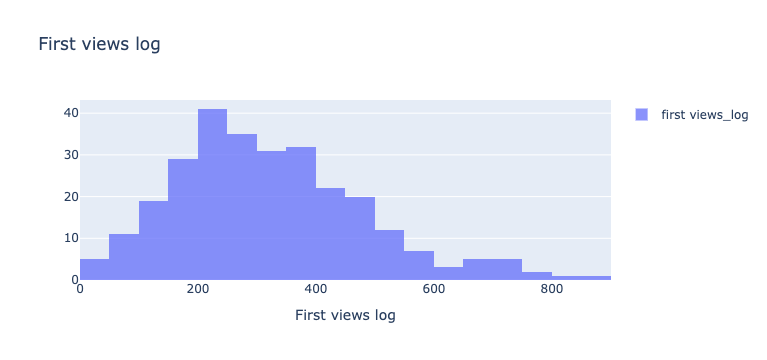

count    2.810000e+02
mean     6.532421e+04
std      2.442548e+05
min      1.200000e+01
25%      1.285000e+03
50%      5.800000e+03
75%      2.835400e+04
max      2.727097e+06
Name: first_views, dtype: float64

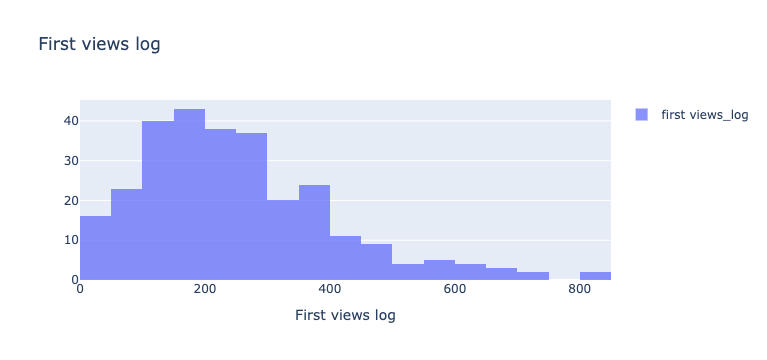

count    2.810000e+02
mean     6.532421e+04
std      2.442548e+05
min      1.200000e+01
25%      1.285000e+03
50%      5.800000e+03
75%      2.835400e+04
max      2.727097e+06
Name: first_views, dtype: float64

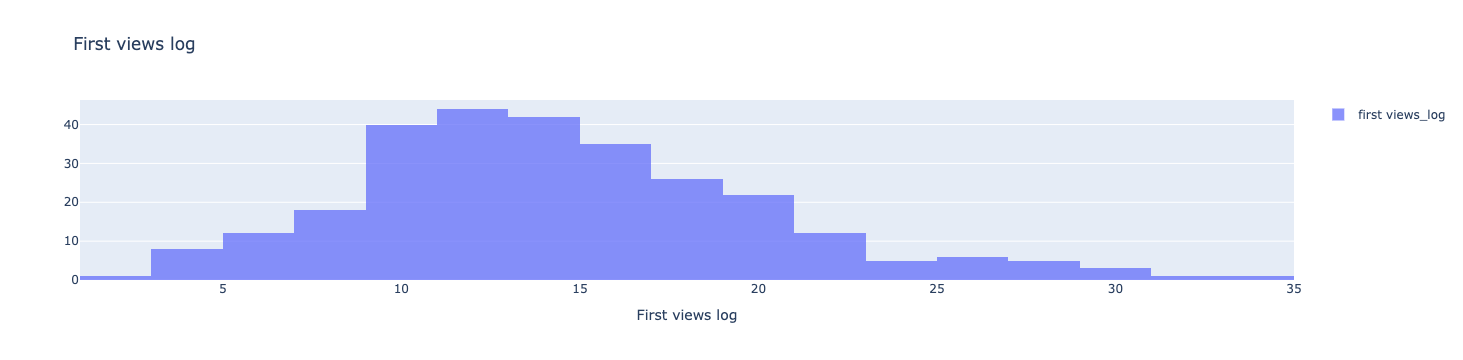

In [1027]:
from scipy import stats 

lmbda=0.001
display(df['first_views'].describe())
df['first_views_log'] = np.log(df['first_views']**2)**2
# df['first_views_log'] = stats.boxcox(df['first_views'], lmbda=lmbda)**2

kwargs={'dflist':[df]  ## List of dataframes 
        ,'varlist':['first_views_log'] ## Variables to be plotted
        ,'title':'First views log'  ## Plot title
        ,'labellist':['first views_log']} ## Labels to be shown in legend
fig = histogram_plot(**kwargs)


lmbda=0.001
display(df['first_views'].describe())
df['first_views_log'] = np.log(df['first_views'])**2.5
# df['first_views_log'] = stats.boxcox(df['first_views'], lmbda=lmbda)**2

kwargs={'dflist':[df]  ## List of dataframes 
        ,'varlist':['first_views_log'] ## Variables to be plotted
        ,'title':'First views log'  ## Plot title
        ,'labellist':['first views_log']} ## Labels to be shown in legend
fig = histogram_plot(**kwargs)

# df['first_views_log'] = stats.boxcox(df['first_views'], lmbda=lmbda)
# df['first_views_l'] = (df['first_views_log']*lmbda+1)**(1/lmbda)
lmbda=0.1
display(df['first_views'].describe())
df['first_views_log'] = stats.boxcox(df['first_views'], lmbda=lmbda)

kwargs={'dflist':[df]  ## List of dataframes 
        ,'varlist':['first_views_log'] ## Variables to be plotted
        ,'title':'First views log'  ## Plot title
        ,'labellist':['first views_log']} ## Labels to be shown in legend
fig = histogram_plot(**kwargs)

## Evaluation

In [741]:
def get_baseline_clean(df_actual):
    ## Get median (clean training data)
#     median_filter = (df_actual.effective_start_date< date_eval_start_clean)
#     df_median = df_actual[median_filter][grpby_median + ['first_views']].groupby(by=grpby_median).agg({'first_views':'median'}).reset_index()
#     df_median = df_median.rename(columns={'first_views':'first_views_median'})
    
    df_median = df_actual.sort_values(by=['tier','category','start_year_month'])
    grpby_median = ['tier','category']
    df_median['first_views_median'] = (
        df_median.groupby(grpby_median)['first_views'].apply(lambda x: x.expanding().median()))

    grpby_median = ['start_year_month','tier','category']
    df_median = pd.concat([df_median.groupby(grpby_median).tail(1)])
    df_median = df_median[grpby_median + ['first_views_median']]
    
    return df_median

def get_baseline_extrapolated(file_path, date_eval_start, grpby_actual):
    ## Get mixed median (clean + extrapolated training data, aggregate median)
    df_median_mx = pd.read_csv(file_path)
    df_median_mx['effective_start_date'] = pd.to_datetime(df_median_mx['effective_start_date'])
    df_median_mx['start_year_month'] = df_median_mx['effective_start_date'].dt.strftime('%Y-%m')
    
    median_mx_filter = (df_median_mx.effective_start_date<date_eval_start)
    grpby_median = ['tier','category']
    
    df_median_mx = df_median_mx[median_mx_filter][grpby_actual + ['first_views']].groupby(by=grpby_actual).agg({'first_views':'sum'}).reset_index()
    df_median_mx = df_median_mx[grpby_median + ['first_views']].groupby(by=grpby_median).agg({'first_views':'median'}).reset_index()
    df_median_mx = df_median_mx.rename(columns={'first_views':'first_views_median_mx'})
    df_median_mx['date_eval'] = date_eval_start
    df_median_mx['date_eval'] = pd.to_datetime(df_median_mx['date_eval'])
    df_median_mx['eval_year_month'] = df_median_mx['date_eval'].dt.strftime('%Y-%m')
    return df_median_mx

    

## Get actuals & baseline 

## Get actuals 
grpby_actual= ['tier','content_category','category','title_name', 'title_id','season_number','program_type',
        'effective_start_date', 'start_year_month','finished_window_flag']

df_actual_raw = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_0922.csv')
df_actual_raw['effective_start_date'] = pd.to_datetime(df_actual_raw['effective_start_date'])
df_actual_raw['start_year'] = df_actual_raw['effective_start_date'].dt.year
df_actual_raw['start_year_month'] = df_actual_raw['effective_start_date'].dt.strftime('%Y-%m')
df_actual = df_actual_raw[['first_views'] + grpby_actual].groupby(by=grpby_actual).sum().reset_index()

# Get df_eval_actuals
date_eval_start = '2021-04-01'
date_eval_end = '2021-07-01'
test_filter = (df_actual.effective_start_date>=date_eval_start) & (df_actual.effective_start_date<date_eval_end)
df_eval_actuals = df_actual[test_filter] 

## Get clean baseline median; month-tier-category cumulative median
df_median = get_baseline_clean(df_actual)

## Get extrapolated baseline
df_median_mx = []
for date, date_start in zip(['0401','0501', '0601'], ['2021-04-01','2021-05-01', '2021-06-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_{date}.csv'
    df_temp = get_baseline_extrapolated(file_path, date_start, grpby_actual)
    df_median_mx.append(df_temp)
df_median_mx = pd.concat(df_median_mx)
    
# # # ## Get base model (clean + extrapolated training data, day-median summed as total)
# df_median_mx_decay = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_0601.csv')
# df_median_mx_decay = df_median_mx_decay[grpby_median + ['predicted_first_views']].groupby(by=grpby_median).agg({'predicted_first_views':'sum'}).reset_index()
# df_median_mx_decay = df_median_mx_decay.rename(columns={'predicted_first_views':'first_views_median_mx_decay'})



In [1055]:
### Get df_eval 
list_postfix = ['xgb','lgbm','dev', 'dev_a', 'dev_b', 'dev_c']

df_eval = df_eval_actuals.merge(df_median, on=['tier','category', 'start_year_month'], how='left')\
        .merge(df_median_mx, left_on=['tier','category', 'start_year_month'], right_on=['tier','category', 'eval_year_month'],  how='left')\
        .merge(df_pred_xgb[['title_name','tier','category','season_number', 'first_views_xgb']], on=['title_name','tier','category','season_number'], how='left')\
        .merge(df_pred_lgbm[['title_name','tier','category','season_number', 'first_views_lgbm']], on=['title_name','tier','category','season_number'], how='left')\
        .merge(df_pred_dev[['title_name','category','season_number', 'first_views_dev']], on=['title_name','category','season_number'], how='left')\
        .merge(df_pred_dev_a[['title_name','category','season_number', 'first_views_dev_a']], on=['title_name','category','season_number'], how='left')\
        .merge(df_pred_dev_b[['title_name','category','season_number', 'first_views_dev_b']], on=['title_name','category','season_number'], how='left')\
        .merge(df_pred_dev_c[['title_name','category','season_number', 'first_views_dev_c']], on=['title_name','category','season_number'], how='left')\

# print(df_eval.shape)
# print(df_eval.isnull().sum())
# print(df_eval.columns)

df_eval = df_eval.dropna()
df_eval['start_year'] = pd.to_datetime(df_eval['effective_start_date']).dt.year
df_eval['start_month'] = pd.to_datetime(df_eval['effective_start_date']).dt.month
df_eval['start_year_month'] = df_eval['effective_start_date'].dt.strftime('%Y-%m')
df_eval['start_quarter'] = df_eval['effective_start_date'].dt.quarter

evaluate_pred(df_eval, ['median_mx', 'median'] + list_postfix)
evaluate_pred(df_eval[~df_eval.category.isin(['Popcorn', 'Specials'])], ['median_mx', 'median'] + list_postfix)

# for tier, group in df_eval.groupby('tier'):
#     actuals_mean=group['first_views'].mean()
#     actuals_sum=group['first_views'].sum()
#     print('_____________________________________________________________')
#     print(f'Tier {tier} actuals: Count: {group.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
#     for i in pred_list:  
#         mae = MAE(group['first_views'], group[i])
#         pred= group[i].sum()
#         print(f'Tier {tier} {i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals_sum)/actuals_sum*100:.0f}%; pred: {pred:.0f}; ')

# for month, group in df_eval.groupby('start_year_month'):
#     actuals_mean=group['first_views'].mean()
#     actuals_sum=group['first_views'].sum()
#     print('_____________________________________________________________')
#     print(f'Month {month} actuals: Count: {group.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
#     for i in pred_list:  
#         mae = MAE(group['first_views'], group[i])
#         pred= group[i].sum()
#         print(f'Month {month} {i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals_sum)/actuals_sum*100:.0f}%; pred: {pred:.0f}; ')



_____________________________________________________________
Aggregate actuals: Count: 45; Title-level mean: 76690;  Aggregate sum: 3451028
median_mx title-level MAE: 82803; aggregate %error: -12%; pred: 3044789; 
median title-level MAE: 53542; aggregate %error: 22%; pred: 4207036; 
xgb title-level MAE: 53749; aggregate %error: -54%; pred: 1583767; 
lgbm title-level MAE: 65490; aggregate %error: -64%; pred: 1255072; 
dev title-level MAE: 56728; aggregate %error: -47%; pred: 1829505; 
dev_a title-level MAE: 54693; aggregate %error: -19%; pred: 2800061; 
dev_b title-level MAE: 53476; aggregate %error: -11%; pred: 3075709; 
dev_c title-level MAE: 84265; aggregate %error: 54%; pred: 5310145; 

_____________________________________________________________
Aggregate actuals: Count: 40; Title-level mean: 14719;  Aggregate sum: 588779
median_mx title-level MAE: 27020; aggregate %error: 141%; pred: 1417998; 
median title-level MAE: 15964; aggregate %error: 81%; pred: 1064244; 
xgb title-level

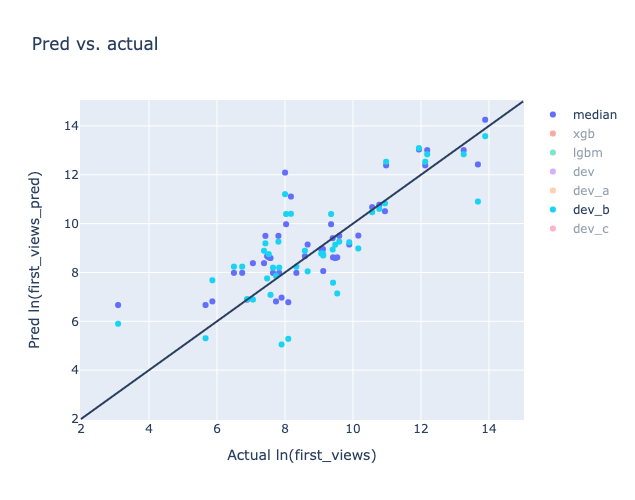

In [1042]:
df_eval['first_views_log'] = np.log(df_eval['first_views'] )
df_eval['first_views_xgb_log'] = np.log(df_eval['first_views_xgb'])
df_eval['first_views_lgbm_log'] = np.log(df_eval['first_views_lgbm'])
df_eval['first_views_dev_log'] = np.log(df_eval['first_views_dev'])
df_eval['first_views_median_log'] = np.log(df_eval['first_views_median'])
df_eval['first_views_dev_a_log'] = np.log(df_eval['first_views_dev_a'])
df_eval['first_views_dev_b_log'] = np.log(df_eval['first_views_dev_b'])
df_eval['first_views_dev_c_log'] = np.log(df_eval['first_views_dev_c'])

data = []
for i in ['median'] + list_postfix :
    data.append(go.Scatter(
                x=df_eval['first_views_log'],
                y=df_eval[f'first_views_{i}_log'],
                mode='markers',
                name=i,
                text=df_eval['start_year_month'] + " " + df_eval['title_name'].astype(str) + ", tier " + df_eval['tier'].astype(str)))

        
py.offline.init_notebook_mode(connected=True) 
fig = go.Figure(data=data)


fig.update_layout(
    title='Pred vs. actual',
    xaxis_title='Actual ln(first_views)',
    yaxis_title='Pred ln(first_views_pred)',
    width=500,
    height=500,
    shapes=[
    dict(
        type= 'line',
        yref= 'y', y0=2, y1= 15,
        xref= 'x', x0=2, x1= 15)])

py.offline.iplot(fig)

# df_eval['diff_median'] = (df_eval['first_views_median']-df_eval['first_views']).abs()
# df_eval['diff'] = (df_eval['first_views_dev_clean']-df_eval['first_views']).abs()
# display(df_eval.sort_values(by='diff', ascending=False).head())
# display(df_eval[df_eval.category.isin(['Specials','Popcorn'])])

In [1067]:
df_eval[df_eval['title_name'].str.contains('Friends')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,start_year_month,finished_window_flag,first_views,first_views_median,first_views_median_mx,date_eval,eval_year_month,first_views_xgb,first_views_lgbm,first_views_dev,first_views_dev_a,first_views_dev_b,first_views_dev_c,start_year,start_month,start_quarter
5,1,special,Specials,Friends: The Reunion,GYJxCDACcN8PDewEAAAAG,0,original,2021-05-27,2021-05,1,867805,248280.0,112657.0,2021-05-01,2021-05,23631.712891,62541.966859,77075.34375,66592.367188,54364.113281,25612.488281,2021,5,2


In [1046]:
df_eval[df_eval['title_name'].isin(['Infinity Train', 'Gomorrah', 'Summer Camp Island', 'Full Bloom'])]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,start_year_month,finished_window_flag,first_views,first_views_median,first_views_median_mx,date_eval,eval_year_month,first_views_xgb,first_views_lgbm,first_views_dev,first_views_dev_a,first_views_dev_b,first_views_dev_c,start_year,start_month,start_quarter,first_views_log,first_views_xgb_log,first_views_lgbm_log,first_views_dev_log,first_views_median_log,first_views_dev_a_log,first_views_dev_b_log,first_views_dev_c_log
29,3,series,International,Gomorrah,GX24uiQjwE7TDLwEAAAAC,4,original,2021-05-20,2021-05,1,979,979.0,910.5,2021-05-01,2021-05,812.798950,484.636993,449.270203,1046.299927,1001.832825,584.073059,2021,5,2,6.886532,6.700484,6.183400,6.107625,6.886532,6.953015,6.909586,6.370026
31,3,series,Kids & Family,Infinity Train,GXkNXsArG_o7CZgEAABfH,4,original,2021-04-15,2021-04,1,3282,880.0,784.0,2021-04-01,2021-04,74.819473,360.346601,57.376530,103.193634,196.848877,124.185478,2021,4,2,8.096208,4.315078,5.887066,4.049635,6.779922,4.636607,5.282436,4.821776
32,3,series,Kids & Family,Summer Camp Island,GXkyDLAgeBY7CZgEAACHO,4,original,2021-06-17,2021-06,1,288,785.5,839.5,2021-06-01,2021-06,106.003204,439.727488,113.617027,181.369644,201.431046,81.780571,2021,6,2,5.662960,4.663469,6.086155,4.732833,6.666320,5.200537,5.305447,4.404040
40,3,series,Unscripted Series,Full Bloom,GX6BA9wumwpbDwgEAAAA4,2,original,2021-06-10,2021-06,1,1160,4358.0,4301.5,2021-06-01,2021-06,1076.194336,1618.419155,983.154785,861.162842,981.382446,967.445312,2021,6,2,7.056175,6.981186,7.389205,6.890767,8.379769,6.758284,6.888962,6.874659


## Model diagnosis

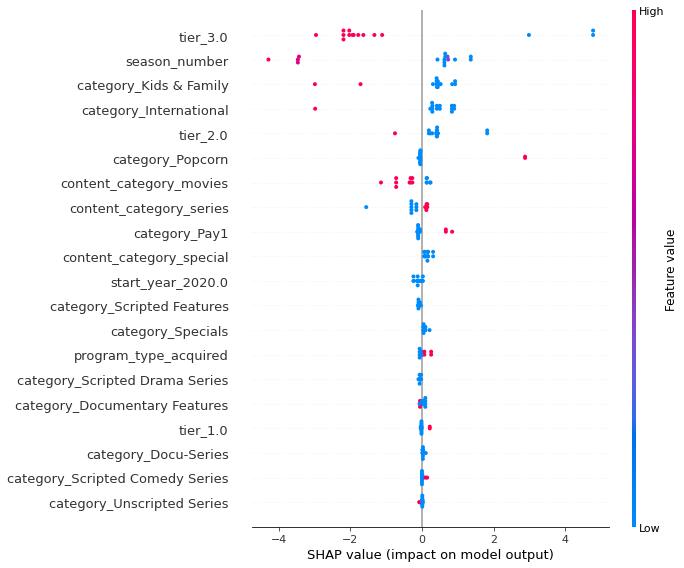

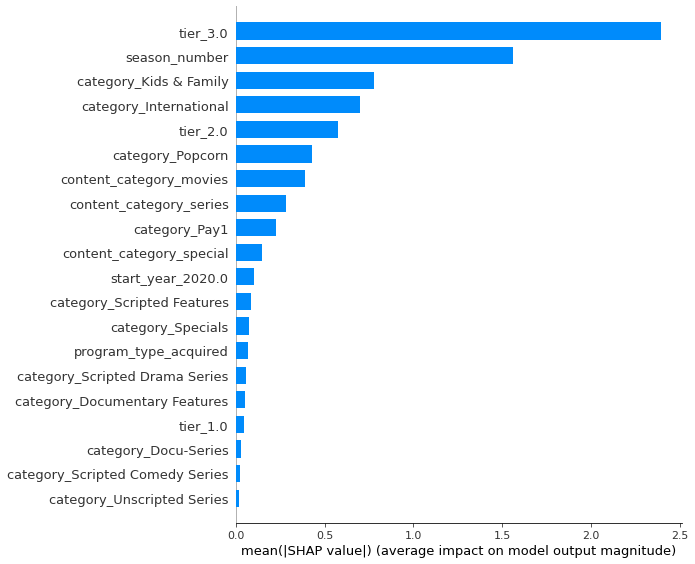

[02:38:23] WARNING: ../src/learner.cc:1238: Empty dataset at worker: 0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [1033]:
import shap
def get_shap(df_pred, model, ohe, features, value=0):
    """
    ev, shap, x_ohe = get_shap(df_pred, 'pop', model_path, 'return')
    shap.force_plot(ev, shap, x_ohe)
    """
    df_x = df_pred[features]

    shap.initjs()
    x_ohe = ohe.transform(df_x)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_ohe)
    
    shap.summary_plot(shap_values, x_ohe)
    shap.summary_plot(shap_values, x_ohe, plot_type="bar")
    return explainer.expected_value, shap_values[value,:], x_ohe.iloc[value,:]

features_cat=[
    'start_year',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont=[
    'season_number',
]

ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont)

ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name=='Infinity Train'], model, ohe, features_cat + features_cont)
shap.force_plot(ev, shap_values, x_ohe)

In [176]:
df_train_in[(df_train_in.content_category=='movies') & (df_train_in.category!='Popcorn')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,tier_new
0,1,movies,Pay1,Tenet,GYEq4eApHYpA4cwEAAAAC,0,acquired,2021-05-02,43052,2.502,2021,5,2021-05,2,10.670164,1
1,1,movies,Pay1,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2021-05-13,70732,0.000,2021,5,2021-05,2,11.166653,1
6,1,movies,Scripted Features,Roald Dahl’s The Witches,GX5A8JQnSPQ2QFgEAAAAC,0,original,2020-10-22,524524,1.737,2020,10,2020-10,4,13.170246,1
7,1,movies,Scripted Features,Zack Snyder's Justice League,GYDAnZgCFQ8IJpQEAAAAN,0,original,2021-03-18,1154956,4.036,2021,3,2021-03,1,13.959573,1
22,2,movies,Documentary Features,The Bee Gees: How Can You Mend A Broken Heart,GX5lfBgOJ7RKRwgEAAAMG,0,original,2020-12-13,49718,1.846,2020,12,2020-12,4,10.814122,2
23,2,movies,Documentary Features,Tina,GYB2e7gq3xivCIgEAAAAb,0,original,2021-03-28,31807,1.962,2021,3,2021-03,1,10.367442,2
24,2,movies,Pay1,Ad Astra,GXo-RygZTqQwlRQEAAAAE,0,acquired,2020-06-07,53772,2.053,2020,6,2020-06,2,10.892508,2
25,2,movies,Pay1,Birds of Prey: Harley Quinn,GXtq0PQyT7MPCwgEAAAaq,0,acquired,2020-08-16,81001,1.814,2020,8,2020-08,3,11.302217,2
26,2,movies,Pay1,Dolittle,GX1oycwoNEsMslAEAAAAI,0,acquired,2020-11-15,37655,1.691,2020,11,2020-11,4,10.536221,2
27,2,movies,Pay1,Ford v Ferrari,GXpTQQAAyyAwlRQEAABgA,0,acquired,2020-06-21,65753,2.548,2020,6,2020-06,2,11.093661,2


In [173]:
df_train_in[(df_train_in.category=='Popcorn')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,tier_new
3,1,movies,Popcorn,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,acquired,2021-03-31,2017162,1.886,2021,3,2021-03,1,14.517202,0
4,1,movies,Popcorn,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,0,acquired,2021-04-23,1074951,1.834,2021,4,2021-04,2,13.887786,0
5,1,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,0
36,2,movies,Popcorn,Judas and the Black Messiah,GYBmsKA4FaUnDdQEAAAAj,0,acquired,2021-02-12,319734,2.091,2021,2,2021-02,1,12.675245,1
38,2,movies,Popcorn,The Little Things,GYA79hQZbUsI3gQEAAAB0,0,acquired,2021-01-29,635584,2.130,2021,1,2021-01,1,13.362300,1
39,2,movies,Popcorn,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,0,acquired,2021-05-14,153249,1.661,2021,5,2021-05,2,11.939819,1
40,2,movies,Popcorn,Tom & Jerry,GYEb9QwLgFF9_ZwEAAAA7,0,acquired,2021-02-26,595699,1.684,2021,2,2021-02,1,13.297491,1


In [196]:
df_pred['diff'] = (df_pred['first_views_dev']-df_pred['first_views']).abs()
df_pred.sort_values(by='diff', ascending=False)

,title_name,title_id,start_year,tier_new,content_category,program_type,category,season_number,first_views,first_views_dev,diff
37,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021,1,movies,acquired,Popcorn,0,571005,243620.062500,327384.937500
35,In The Heights,GYK0x7gXCza4OwwEAAADl,2021,1,movies,acquired,Popcorn,0,195239,243620.062500,48381.062500
44,No Sudden Move,GYMzEGg049ruJvQEAAAAW,2021,2,movies,acquired,Scripted Features,0,49858,26571.292969,23286.707031
29,Judas and the Black Messiah,GYBmsKA4FaUnDdQEAAAAj,2021,2,movies,acquired,Pay1,0,10683,28035.773438,17352.773438
34,The Little Things,GYA79hQZbUsI3gQEAAAB0,2021,2,movies,acquired,Pay1,0,38699,28035.773438,10663.226562
142,Fatale,GYHmDAQRp2grCFgEAAAAC,2021,3,movies,acquired,Pay1,0,14697,5685.003418,9011.996582
73,Tom & Jerry in New York,GYMDm0AJXAH0LrgEAAAAF,2021,2,series,original,Kids & Family,1,5113,10089.482422,4976.482422
246,All That Glitters,GYNHTDQuvpMLCewEAAAAG,2021,3,series,original,Unscripted Series,1,1609,5323.430176,3714.430176
147,Kajillionaire,GYIHBbgg_NZ2TjQEAAADx,2021,3,movies,acquired,Pay1,0,2456,5685.003418,3229.003418
133,Juan Luis Guerra 4.40: Entre Mar y Palmeras,GYJ1S5Qt5TG2gdAEAAABv,2021,3,movies,original,International,0,2695,153.333191,2541.666809
